<a href="https://www.kaggle.com/code/rodrigoclporto/solving-linkedin-zip-with-pyomo?scriptVersionId=290952340" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Solving LinkedIn Zip with Linear Optimization

Continuing with the challenge of solving LinkedIn's minigames using <abbr title="Linear Optimization">LO</abbr>, just like I did with [Queens](./1_solving_linkedin_queens.ipynb) and [Tango](./2_solving_linkedin_tango.ipynb), the next one I've chosen is **Zip**, which turned out to be the most challenging so far.

# How to Play Zip

<figure style="text-align:center;">
    <figcaption>Zip game board No. 166, 08/29/2025</figcaption>
    <img src="https://cdn.jsdelivr.net/gh/rodrigo-cl-porto/Solving-LinkedIn-Minigames-with-Linear-Optimization/assets/zip_example.png" style="width:30%;">
    <figcaption>Source: LinkedIn</figcaption>
</figure>

The Zip game board consists of a square grid with several numbered spaces. Both the total number of spaces and the number of numbered spaces can vary from game to game. The objective is to trace a path that runs through all the spaces on the board, moving the numbered spaces in ascending order, starting from space number 1 to the space with the highest number.

# Problem Modeling

The best way I thought of to solve the game is to consider the squares as nodes in a **directed graph** (digraph), where each node has a set of pairs of edges that arrive at and depart from the nodes, as shown in the following figure.

<figure style="text-align:center;">
    <figcaption>Zip game modeled on a directed graph</figcaption>
    <img src="https://cdn.jsdelivr.net/gh/rodrigo-cl-porto/Solving-LinkedIn-Minigames-with-Linear-Optimization/assets/zip_graph_model.png" style="width:30%;">
    <figcaption>Source: created by the author himself</figcaption>
</figure>

Considering this model, enacted the Abstract <abbr title="Linear Optimization">LO</abbr> Model by defining its following components:

- **Ranges**
- **Sets**
- **Decision Variables**
- **Objective Function**
- **Constraints**

## Ranges

To properly formulate the <abbr title="Linear Optimization">LO</abbr> model, we will start from the premise that the squares on the board will be the Cartesian product of the ranges $I$ of rows and $J$ of columns present on the board. In addition, it is necessary to have defined an interval $K$ for the set of numbered squares.

- $I = \{1, \cdots, n\}$ represents the range of rows, where $n$ is the total number of rows (in this case, $n = 6$);
- $J = \{1, \cdots, m\}$ represents the range of columns, where $m$ is the total number of columns (in this case, $m = 6$ as well).
- $K = \{1, \cdots, p\}, 2 \le p \le |V| = nm$ represents the range of numbered squares, where the total number of numbered squares $p$ must not exceed the total number of vertices.

## Sets

This time, the definition of sets will be more than fundamental to reducing the complexity of the model, as we will avoid having to deal with numerous exceptions. From the ranges determined previously, we can define the set of vertices ($V$) and edges ($E$) existing in the network logic. In addition to these, it is also necessary to consider the subsets of numbered vertices ($N$) and blocked edges ($W$), since, in some instances of Zip game, there may be walls between two squares that prevent the path from being traced between them.

- $V$ is the set of all squares (vertices). There must be at least 2 vertices in the grid, as it is only possible to trace a path with an initial and a final square. Therefore, $|V| \ge 2$.

$$V = \{(i,j) \mid \forall i \in I, \forall j \in J \}$$

- $E$ is the set of all edges present in the graph. Its definition will be a bit more complex, as it is necessary to clarify that, for each vertex, there will only be edges between neighbors immediately to the left, immediately to the right, immediately above, and immediately below it, if they exist.

$$
E = \begin{array}{lr}
    \{((i,j), (i+1,j)) \mid (i,j) \in V, i + 1 \in I \} & \cup \\
    \{((i,j), (i-1,j)) \mid (i,j) \in V, i - 1 \in I \} & \cup \\
    \{((i,j), (i,j+1)) \mid (i,j) \in V, j + 1 \in J \} & \cup \\
    \{((i,j), (i,j-1)) \mid (i,j) \in V, j - 1 \in J \} &
\end{array}
$$

- $N \subseteq V$ is the set of numbered squares, which will consist of a set of vertices indexed by a $k \in K$ that represents the respective vertex number.

$$N = \{v_k \mid k \in K, v_k \in V\}$$

- $W \subset E$ is the set of blocked edges (walls) that may appear on the grid.

## Decision Variables

By using the network logic already presented, it is possible to define the edges as binary decision variables $x_{ijrs}$, which again makes our <abbr title="Linear Optimization Problem">LOP</abbr> a **<abbr title="Binary Linear Optimization Problem">BLOP</abbr>**. In addition to $x_{ijrs}$, variables $u_{ij}$ will also be considered, representing the absolute ordinal position of the square $(i, j)$ within the path (these variables will be better explained later).

- $x_{ijrs}$ will be equal to 1 if the edge that starts from square $(i,j)$ and arrives at square $(r,s)$ is part of the path; 0 otherwise.
- $u_{ij}$ represents the absolute ordinal position of the square $(i,j)$ within the path.

## Objective Function

Once again, just as in the Queens and Tango minigames, our problem does not have a function to be optimized, since we only want to find a solution that fulfills all the rules of the game. Therefore, Zip's <abbr title="Binary Linear Optimization Problem">BLOP</abbr> is a **feasibility problem**, and the objective function of the model consists of maximizing (or minimizing) an arbitrary constant.

$$\text{Max} \ C$$

## Constraints

**Decision variables domain constraints** — First, let's not forget to define our variables $x_{ijrs}$ as binary and the variables $u_{ij}$ as non-negative real numbers. To simplify, whenever possible, we can replace the notation $x_{ijrs}$ with $x_{vw}$ and $u_{ij}$ with just $u_v$, since the sequence $(i, j) = v$ always refers to some vertex belonging to $V$ set.

$$
\begin{array}{}
x_{v,w} \in \{0,1\}, \forall (v,w) \in E \\
u_v \ge 0, \forall v \in V
\end{array}
$$

**Blocked edges constraints** — If there is a wall between a pair of squares, then the sum of the edges connecting those ones must be equal to 0.

$$x_{v,w} + x_{w,v} = 0, \forall (v,w) \in W$$

**Continuity constraints** — Since it is only possible to enter and exit a node once (except for the initial and destination nodes), then we will have the following:

- The sum of the edges emanating from a node must equal 1 (except for the destination square).

$$\sum_{w \in V}{x_{v,w}} = 1, (v,w) \in E, \forall v \in V \backslash \{v_p\}$$

- The sum of the edges arriving at a node must equal 1 (except for the initial square).

$$\sum_{v \in V}{x_{v,w}} = 1, (v,w) \in E, \forall w \in V \backslash \{w_1\}$$

- The sum of the edges emanating from the destination node must be 0.

$$\sum_{w \in V}{x_{v_p,w}} = 0, (v_p,w) \in E$$

- The sum of the edges arriving at the initial node must be 0.

$$\sum_{v \in V}{x_{v,w_1}} = 0, (v,w_1) \in E$$

It only makes sense to apply the last two constraints if the edges entering the initial square and exiting the destination square have already been removed from the graph, but I included them because I started from a model where the initial and destination nodes can be changed from game to game without needing to alter the basic structure of the graph.

If it were a complete digraph, where all vertices were connected to each other, the number of constraints needed to guarantee the elimination of any cycle would be on the exponential order of $2^{|V|+1}$. That is, for our graph of 36 squares, this would represent, in the worst case, formulating a PPLB model with no less than $2^{37} = 137,438,953,472$ constraints!

Furthermore, since a square can only be visited once, it also makes sense to include a set of constraints to prevent the selection of a pair of edges that enter and exit the same square, forming a cycle (sub-route) in the graph. However, in addition to the constraints for eliminating cycles composed of 2 decimal places, it would also be necessary to include constraints to prevent cycles of 3, 4… up to 34 decimal places in our case, which would require a monstrous number of constraints.

Fortunately, the number of constraints for eliminating cycles is immensely reduced if the **Miller-Tucker-Zemlin** (MZT) formulation is used, shown below.

**Subroute Elimination Constraints** — The advantage of the <abbr title="Miller-Tucker-Zemlin">MZT</abbr> formulation is that the number of constraints to be included to guarantee subroute elimination is equal to $|E| = 4nm — 2n — 2m$, that is, the number of edges in the graph. Thus, the number of constraints grows linearly as a function of the number of edges, instead of exponentially as a function of the number of vertices. For it to work, it requires the addition of more decision variables (the previously mentioned $u_{ij}$), which represent the absolute ordinal position of square $(i, j)$ within the path.

- First, the position of the starting square must be equal to 1, since it will always be the first position on the path.

$$u_{v_1} = 1$$

- Then, the positions of the remaining squares on the board should be given as follows.

$$u_w \ge u_v + 1 - M(1 - x_{v,w}), w \in V \backslash \{w_1\}, \forall (v,w) \in E$$

In this formulation, $M$ corresponds to a constant whose value is large enough to cover all possible positions a square can assume on the path. Therefore, a sufficiently large value of $M$ corresponds to $M = |V|$, that is, $M$ must be at least equal to the number of squares on the board (which in our particular case is 36).

To better understand the <abbr title="Miller-Tucker-Zemlin">MZT</abbr> formulation, we will see that, if $x_{ij} = 1$, the restriction reduces to $u_w ≥ u_v + 1$. Thus, the position of the subsequent square will be at least equal to the subsequent position of the previous square, which guarantees that square $w$ "is ahead" of square $v$. However, if $x_{vw} = 0$, then the constraint will be $u_w \ge u_v + 1 – 36 \implies u_w - u_v \ge –35$, which will always be true since it relaxes the constraint enough to be satisfied for any feasible value for $u_v$ and $u_w$. Therefore, the term $M(1 – x_{vw})$ ends up serving as a “switch” that turns the constraint on and off depending on whether the edge $(v,w)$ is part of the path or not; and that's what makes this formulation ingenious!

- Although not necessary, one can restrict the position of the destination square to be equal to the number of squares on the board, just to make the $u_v$ range from 1 to 36.

$$u_{v_p} = |V|$$

**Order of precedence constraint** — In order for the path to traverse the numbered squares in ascending numerical order, it is necessary to impose the constraint that the position of a numbered square $i$ must be at least equal to the position subsequent to the last numbered square.

$$u_{v_k} \ge u_{v_{k-1}} + 1, \forall k \in K \backslash \{1\}$$

# Abstract Model

With all the formulas elaborated, we have the complete abstract model for the Zip minigame.

$$
\begin{array}{lll}
    & \text{Max} \ C & \\
    \text{S.a.:} & & \\
    & \sum_{w \in V}{x_{vw}}=1, & (v,w) \in E, \forall v \in V \backslash \{v_p\} \\
    & \sum_{v \in V}{x_{v_p,w}}=0 ,& (v_p,w) \in E \\
    & \sum_{v \in V}{x_{vw}}=1, & (v,w) \in E, \forall w \in V \backslash \{w_1\} \\
    & \sum_{v \in V}{x_{v,w_1}}=0, & (v,w_1) \in E \\
    & x_{vw} + x_{wv} = 0, & \forall (v,w) \in W \\
    & u_{v_1} = 1 & \\
    & u_{v_p} = |V| & \\
    & u_w \ge u_v + 1 - |V|(1-x_{v,w}), & w \in V \backslash \{w_1\}, \forall (v,w) \in E \\
    & u_{v_k} \ge u_{v_{k-1}} + 1, & \forall k \in K \backslash \{1\} \\
    & x_{vw} \in \{0,1\}, & \forall (v,w) \in E \\
    & u_v \ge 0, & \forall v \in V
\end{array}
$$

# Concrete Model

For our specific case of a 6 $\times$ 6 grid game, we have the following concrete model:

**Objective Function**

- $\text{Max} \ 0$

**Subject to**:

(_Outgoing edges constraints_)

- $x_{1112} + x_{1121} = 1$ (_Square (1,1)_)
- $x_{1211} + x_{1222} + x_{1213} = 1$ (_Square (1,2)_)
- $x_{1312} + x_{1323} + x_{1314} = 1$ (_Square (1,3)_)
- $x_{1413} + x_{1424} + x_{1415} = 1$ (_Square (1,4)_)
- $x_{1514} + x_{1525} + x_{1516} = 1$ (_Square (1,5)_)
- $x_{1615} + x_{1626} = 1$ (_Square (1,6)_)
- $x_{2111} + x_{2122} + x_{2131} = 1$ (_Square (2,1)_)
- $x_{2212} + x_{2221} + x_{2223} + x_{2232} = 1$ (_Square (2,2)_)
- $x_{2313} + x_{2322} + x_{2324} + x_{2333} = 1$ (_Square (2,3)_)
- $x_{2414} + x_{2423} + x_{2425} + x_{2434} = 1$ (_Square (2,4)_)
- $x_{2515} + x_{2524} + x_{2526} + x_{2535} = 1$ (_Square (2,5)_)
- $x_{2616} + x_{2625} + x_{2636} = 1$ (_Square (2,6)_)
- $x_{3121} + x_{3132} + x_{3141} = 1$ (_Square (3,1)_)
- $x_{3222} + x_{3231} + x_{3233} + x_{3242} = 1$ (_Square (3,2)_)
- $x_{3323} + x_{3332} + x_{3334} + x_{3343} = 1$ (_Square (3,3)_)
- $x_{3424} + x_{3433} + x_{3435} + x_{3444} = 1$ (_Square (3,4)_)
- $x_{3525} + x_{3534} + x_{3536} + x_{3545} = 1$ (_Square (3,5)_)
- $x_{3626} + x_{3635} + x_{3646} = 1$ (_Square (3,6)_)
- $x_{4131} + x_{4142} + x_{4151} = 1$ (_Square (4,1)_)
- $x_{4232} + x_{4241} + x_{4243} + x_{4252} = 1$ (_Square (4,2)_)
- $x_{4333} + x_{4342} + x_{4344} + x_{4353} = 1$ (_Square (4,3)_)
- $x_{4434} + x_{4443} + x_{4445} + x_{4454} = 1$ (_Square (4,4)_)
- $x_{4535} + x_{4544} + x_{4546} + x_{4555} = 1$ (_Square (4,5)_)
- $x_{4636} + x_{4645} + x_{4656} = 0$ (_Square (4,6)_)
- $x_{5141} + x_{5152} + x_{5161} = 1$ (_Square (5,1)_)
- $x_{5242} + x_{5251} + x_{5253} + x_{5262} = 1$ (_Square (5,2)_)
- $x_{5343} + x_{5352} + x_{5354} + x_{5363} = 1$ (_Square (5,3)_)
- $x_{5444} + x_{5453} + x_{5455} + x_{5464} = 1$ (_Square (5,4)_)
- $x_{5545} + x_{5554} + x_{5556} + x_{5565} = 1$ (_Square (5,5)_)
- $x_{5646} + x_{5655} + x_{5666} = 1$ (_Square (5,6)_)
- $x_{6151} + x_{6162} = 1$ (_Square (6,1)_)
- $x_{6252} + x_{6261} + x_{6263} = 1$ (_Square (6,2)_)
- $x_{6353} + x_{6362} + x_{6364} = 1$ (_Square (6,3)_)
- $x_{6454} + x_{6463} + x_{6465} = 1$ (_Square (6,4)_)
- $x_{6555} + x_{6564} + x_{6566} = 1$ (_Square (6,5)_)
- $x_{6656} + x_{6665} = 1$ (_Square (6,6)_)

(_Incoming edges cosntraints_)

- $x_{1211} + x_{2111} = 1$ (_Square (1,1)_)
- $x_{1112} + x_{2212} + x_{1312} = 1$ (_Square (1,2)_)
- $x_{1213} + x_{2313} + x_{1413} = 1$ (_Square (1,3)_)
- $x_{1314} + x_{2414} + x_{1514} = 1$ (_Square (1,4)_)
- $x_{1415} + x_{2515} + x_{1615} = 1$ (_Square (1,5)_)
- $x_{1516} + x_{2616} = 1$ (_Square (1,6)_)
- $x_{1121} + x_{2221} + x_{3121} = 1$ (_Square (2,1)_)
- $x_{1222} + x_{2122} + x_{2322} + x_{3222} = 1$ (_Square (2,2)_)
- $x_{1323} + x_{2223} + x_{2423} + x_{3323} = 1$ (_Square (2,3)_)
- $x_{1424} + x_{2324} + x_{2524} + x_{3424} = 1$ (_Square (2,4)_)
- $x_{1525} + x_{2425} + x_{2625} + x_{3525} = 1$ (_Square (2,5)_)
- $x_{1626} + x_{2526} + x_{3626} = 1$ (_Square (2,6)_)
- $x_{2131} + x_{3231} + x_{4131} = 1$ (_Square (3,1)_)
- $x_{2232} + x_{3132} + x_{3332} + x_{4232} = 1$ (_Square (3,2)_)
- $x_{2333} + x_{3233} + x_{3433} + x_{4333} = 1$ (_Square (3,3)_)
- $x_{2434} + x_{3334} + x_{3534} + x_{4434} = 1$ (_Square (3,4)_)
- $x_{2535} + x_{3435} + x_{3635} + x_{4535} = 1$ (_Square (3,5)_)
- $x_{2636} + x_{3536} + x_{4636} = 1$ (_Square (3,6)_)
- $x_{3141} + x_{4241} + x_{5141} = 1$ (_Square (4,1)_)
- $x_{3242} + x_{4142} + x_{4342} + x_{5242} = 1$ (_Square (4,2)_)
- $x_{3343} + x_{4243} + x_{4443} + x_{5343} = 1$ (_Square (4,3)_)
- $x_{3444} + x_{4344} + x_{4544} + x_{5444} = 1$ (_Square (4,4)_)
- $x_{3545} + x_{4445} + x_{4645} + x_{5545} = 1$ (_Square (4,5)_)
- $x_{3646} + x_{4546} + x_{5646} = 1$ (_Square (4,6)_)
- $x_{4151} + x_{5251} + x_{6151} = 1$ (_Square (5,1)_)
- $x_{4252} + x_{5152} + x_{5352} + x_{6252} = 1$ (_Square (5,2)_)
- $x_{4353} + x_{5253} + x_{5453} + x_{6353} = 1$ (_Square (5,3)_)
- $x_{4454} + x_{5354} + x_{5554} + x_{6454} = 1$ (_Square (5,4)_)
- $x_{4555} + x_{5455} + x_{5655} + x_{6555} = 1$ (_Square (5,5)_)
- $x_{4656} + x_{5556} + x_{6656} = 1$ (_Square (5,6)_)
- $x_{5161} + x_{6261} = 1$ (_Square (6,1)_)
- $x_{5262} + x_{6162} + x_{6362} = 1$ (_Square (6,2)_)
- $x_{5363} + x_{6263} + x_{6463} = 1$ (_Square (6,3)_)
- $x_{5464} + x_{6364} + x_{6564} = 1$ (_Square (6,4)_)
- $x_{5565} + x_{6465} + x_{6665} = 0$ (_Square (6,5)_)
- $x_{5666} + x_{6566} = 1$ (_Square (6,6)_)

(_Ordinal position constraints_)

- $u_{65} = 1$ (_Square 1_)
- $u_{66} \ge u_{65} + 1$ (_Square 2_)
- $u_{56} \ge u_{66} + 1$ (_Square 3_)
- $u_{64} \ge u_{56} + 1$ (_Square 4_)
- $u_{53} \ge u_{64} + 1$ (_Square 5_)
- $u_{42} \ge u_{53} + 1$ (_Square 6_)
- $u_{31} \ge u_{42} + 1$ (_Square 7_)
- $u_{21} \ge u_{31} + 1$ (_Square 8_)
- $u_{11} \ge u_{21} + 1$ (_Square 9_)
- $u_{12} \ge u_{11} + 1$ (_Square 10_)
- $u_{13} \ge u_{12} + 1$ (_Square 11_)
- $u_{35} \ge u_{13} + 1$ (_Square 12_)
- $u_{24} \ge u_{35} + 1$ (_Square 13_)
- $u_{34} \ge u_{24} + 1$ (_Square 14_)
- $u_{43} \ge u_{34} + 1$ (_Square 15_)
- $u_{46} \ge u_{43} + 1$ (_Square 16_)
- $u_{46} = 36$ (_Square 16_)

(_Subroute elimination - <abbr title="Miller-Tucker-Zemlin">MZT</abbr> - constraints_)

- $u_{11} \ge u_{12} + 1 – 36(1 – x_{1211})$
- $u_{11} \ge u_{21} + 1 – 36(1 – x_{2111})$
- $u_{12} \ge u_{11} + 1 – 36(1 – x_{1112})$
- $u_{12} \ge u_{22} + 1 – 36(1 – x_{2212})$
- $u_{12} \ge u_{13} + 1 – 36(1 – x_{1312})$
- $u_{13} \ge u_{12} + 1 – 36(1 – x_{1213})$
- $u_{13} \ge u_{23} + 1 – 36(1 – x_{2313})$
- $u_{13} \ge u_{14} + 1 – 36(1 – x_{1413})$
- $u_{14} \ge u_{13} + 1 – 36(1 – x_{1314})$
- $u_{14} \ge u_{24} + 1 – 36(1 – x_{2414})$
- $u_{14} \ge u_{15} + 1 – 36(1 – x_{1514})$
- $u_{15} \ge u_{14} + 1 – 36(1 – x_{1415})$
- $u_{15} \ge u_{25} + 1 – 36(1 – x_{2515})$
- $u_{15} \ge u_{16} + 1 – 36(1 – x_{1615})$
- $u_{16} \ge u_{15} + 1 – 36(1 – x_{1516})$
- $u_{16} \ge u_{26} + 1 – 36(1 – x_{2616})$
- $u_{21} \ge u_{11} + 1 – 36(1 – x_{1121})$
- $u_{21} \ge u_{22} + 1 – 36(1 – x_{2221})$
- $u_{21} \ge u_{31} + 1 – 36(1 – x_{3121})$
- $u_{22} \ge u_{12} + 1 – 36(1 – x_{1222})$
- $u_{22} \ge u_{21} + 1 – 36(1 – x_{2122})$
- $u_{22} \ge u_{23} + 1 – 36(1 – x_{2322})$
- $u_{22} \ge u_{32} + 1 – 36(1 – x_{3222})$
- $u_{23} \ge u_{13} + 1 – 36(1 – x_{1323})$
- $u_{23} \ge u_{22} + 1 – 36(1 – x_{2223})$
- $u_{23} \ge u_{24} + 1 – 36(1 – x_{2423})$
- $u_{23} \ge u_{33} + 1 – 36(1 – x_{3323})$
- $u_{24} \ge u_{14} + 1 – 36(1 – x_{1424})$
- $u_{24} \ge u_{23} + 1 – 36(1 – x_{2324})$
- $u_{24} \ge u_{25} + 1 – 36(1 – x_{2524})$
- $u_{24} \ge u_{34} + 1 – 36(1 – x_{3424})$
- $u_{25} \ge u_{15} + 1 – 36(1 – x_{1525})$
- $u_{25} \ge u_{24} + 1 – 36(1 – x_{2425})$
- $u_{25} \ge u_{26} + 1 – 36(1 – x_{2625})$
- $u_{25} \ge u_{35} + 1 – 36(1 – x_{3525})$
- $u_{26} \ge u_{16} + 1 – 36(1 – x_{1626})$
- $u_{26} \ge u_{25} + 1 – 36(1 – x_{2526})$
- $u_{26} \ge u_{36} + 1 – 36(1 – x_{3626})$
- $u_{31} \ge u_{21} + 1 – 36(1 – x_{2131})$
- $u_{31} \ge u_{32} + 1 – 36(1 – x_{3231})$
- $u_{31} \ge u_{41} + 1 – 36(1 – x_{4131})$
- $u_{32} \ge u_{22} + 1 – 36(1 – x_{2232})$
- $u_{32} \ge u_{31} + 1 – 36(1 – x_{3132})$
- $u_{32} \ge u_{33} + 1 – 36(1 – x_{3332})$
- $u_{32} \ge u_{42} + 1 – 36(1 – x_{4232})$
- $u_{33} \ge u_{23} + 1 – 36(1 – x_{2333})$
- $u_{33} \ge u_{32} + 1 – 36(1 – x_{3233})$
- $u_{33} \ge u_{34} + 1 – 36(1 – x_{3433})$
- $u_{33} \ge u_{43} + 1 – 36(1 – x_{4333})$
- $u_{34} \ge u_{24} + 1 – 36(1 – x_{2434})$
- $u_{34} \ge u_{33} + 1 – 36(1 – x_{3334})$
- $u_{34} \ge u_{35} + 1 – 36(1 – x_{3534})$
- $u_{34} \ge u_{44} + 1 – 36(1 – x_{4434})$
- $u_{35} \ge u_{25} + 1 – 36(1 – x_{2535})$
- $u_{35} \ge u_{34} + 1 – 36(1 – x_{3435})$
- $u_{35} \ge u_{36} + 1 – 36(1 – x_{3635})$
- $u_{35} \ge u_{45} + 1 – 36(1 – x_{4535})$
- $u_{36} \ge u_{26} + 1 – 36(1 – x_{2636})$
- $u_{36} \ge u_{35} + 1 – 36(1 – x_{3536})$
- $u_{36} \ge u_{46} + 1 – 36(1 – x_{4636})$
- $u_{41} \ge u_{31} + 1 – 36(1 – x_{3141})$
- $u_{41} \ge u_{42} + 1 – 36(1 – x_{4241})$
- $u_{41} \ge u_{51} + 1 – 36(1 – x_{5141})$
- $u_{42} \ge u_{32} + 1 – 36(1 – x_{3242})$
- $u_{42} \ge u_{41} + 1 – 36(1 – x_{4142})$
- $u_{42} \ge u_{43} + 1 – 36(1 – x_{4342})$
- $u_{42} \ge u_{52} + 1 – 36(1 – x_{5242})$
- $u_{43} \ge u_{33} + 1 – 36(1 – x_{3343})$
- $u_{43} \ge u_{42} + 1 – 36(1 – x_{4243})$
- $u_{43} \ge u_{44} + 1 – 36(1 – x_{4443})$
- $u_{43} \ge u_{53} + 1 – 36(1 – x_{5343})$
- $u_{44} \ge u_{34} + 1 – 36(1 – x_{3444})$
- $u_{44} \ge u_{43} + 1 – 36(1 – x_{4344})$
- $u_{44} \ge u_{45} + 1 – 36(1 – x_{4544})$
- $u_{44} \ge u_{54} + 1 – 36(1 – x_{5444})$
- $u_{45} \ge u_{35} + 1 – 36(1 – x_{3545})$
- $u_{45} \ge u_{44} + 1 – 36(1 – x_{4445})$
- $u_{45} \ge u_{46} + 1 – 36(1 – x_{4645})$
- $u_{45} \ge u_{55} + 1 – 36(1 – x_{5545})$
- $u_{46} \ge u_{36} + 1 – 36(1 – x_{3646})$
- $u_{46} \ge u_{45} + 1 – 36(1 – x_{4546})$
- $u_{46} \ge u_{56} + 1 – 36(1 – x_{5646})$
- $u_{51} \ge u_{41} + 1 – 36(1 – x_{4151})$
- $u_{51} \ge u_{52} + 1 – 36(1 – x_{5251})$
- $u_{51} \ge u_{61} + 1 – 36(1 – x_{6151})$
- $u_{52} \ge u_{42} + 1 – 36(1 – x_{4252})$
- $u_{52} \ge u_{51} + 1 – 36(1 – x_{5152})$
- $u_{52} \ge u_{53} + 1 – 36(1 – x_{5352})$
- $u_{52} \ge u_{62} + 1 – 36(1 – x_{6252})$
- $u_{53} \ge u_{43} + 1 – 36(1 – x_{4353})$
- $u_{53} \ge u_{52} + 1 – 36(1 – x_{5253})$
- $u_{53} \ge u_{54} + 1 – 36(1 – x_{5453})$
- $u_{53} \ge u_{63} + 1 – 36(1 – x_{6353})$
- $u_{54} \ge u_{44} + 1 – 36(1 – x_{4454})$
- $u_{54} \ge u_{53} + 1 – 36(1 – x_{5354})$
- $u_{54} \ge u_{55} + 1 – 36(1 – x_{5554})$
- $u_{54} \ge u_{64} + 1 – 36(1 – x_{6454})$
- $u_{55} \ge u_{45} + 1 – 36(1 – x_{4555})$
- $u_{55} \ge u_{54} + 1 – 36(1 – x_{5455})$
- $u_{55} \ge u_{56} + 1 – 36(1 – x_{5655})$
- $u_{55} \ge u_{65} + 1 – 36(1 – x_{6555})$
- $u_{56} \ge u_{46} + 1 – 36(1 – x_{4656})$
- $u_{56} \ge u_{55} + 1 – 36(1 – x_{5556})$
- $u_{56} \ge u_{66} + 1 – 36(1 – x_{6656})$
- $u_{61} \ge u_{51} + 1 – 36(1 – x_{5161})$
- $u_{61} \ge u_{62} + 1 – 36(1 – x_{6261})$
- $u_{62} \ge u_{52} + 1 – 36(1 – x_{5262})$
- $u_{62} \ge u_{61} + 1 – 36(1 – x_{6162})$
- $u_{62} \ge u_{63} + 1 – 36(1 – x_{6362})$
- $u_{63} \ge u_{53} + 1 – 36(1 – x_{5363})$
- $u_{63} \ge u_{62} + 1 – 36(1 – x_{6263})$
- $u_{63} \ge u_{64} + 1 – 36(1 – x_{6463})$
- $u_{64} \ge u_{54} + 1 – 36(1 – x_{5464})$
- $u_{64} \ge u_{63} + 1 – 36(1 – x_{6364})$
- $u_{64} \ge u_{65} + 1 – 36(1 – x_{6564})$
- $u_{65} \ge u_{55} + 1 – 36(1 – x_{5565})$
- $u_{65} \ge u_{64} + 1 – 36(1 – x_{6465})$
- $u_{65} \ge u_{66} + 1 – 36(1 – x_{6665})$
- $u_{66} \ge u_{56} + 1 – 36(1 – x_{5666})$
- $u_{66} \ge u_{65} + 1 – 36(1 – x_{6566})$

(_Binarity constraints for edge variables_)

- $x_{1112} \in \{0,1\}$
- $x_{1121} \in \{0,1\}$
- $x_{1211} \in \{0,1\}$
- $x_{1222} \in \{0,1\}$
- $x_{1213} \in \{0,1\}$
- $x_{1312} \in \{0,1\}$
- $x_{1323} \in \{0,1\}$
- $x_{1314} \in \{0,1\}$
- $x_{1413} \in \{0,1\}$
- $x_{1424} \in \{0,1\}$
- $x_{1415} \in \{0,1\}$
- $x_{1514} \in \{0,1\}$
- $x_{1525} \in \{0,1\}$
- $x_{1516} \in \{0,1\}$
- $x_{1615} \in \{0,1\}$
- $x_{1626} \in \{0,1\}$
- $x_{2111} \in \{0,1\}$
- $x_{2122} \in \{0,1\}$
- $x_{2131} \in \{0,1\}$
- $x_{2212} \in \{0,1\}$
- $x_{2221} \in \{0,1\}$
- $x_{2223} \in \{0,1\}$
- $x_{2232} \in \{0,1\}$
- $x_{2313} \in \{0,1\}$
- $x_{2322} \in \{0,1\}$
- $x_{2324} \in \{0,1\}$
- $x_{2333} \in \{0,1\}$
- $x_{2414} \in \{0,1\}$
- $x_{2423} \in \{0,1\}$
- $x_{2425} \in \{0,1\}$
- $x_{2434} \in \{0,1\}$
- $x_{2515} \in \{0,1\}$
- $x_{2524} \in \{0,1\}$
- $x_{2526} \in \{0,1\}$
- $x_{2535} \in \{0,1\}$
- $x_{2616} \in \{0,1\}$
- $x_{2625} \in \{0,1\}$
- $x_{2636} \in \{0,1\}$
- $x_{3121} \in \{0,1\}$
- $x_{3132} \in \{0,1\}$
- $x_{3141} \in \{0,1\}$
- $x_{3222} \in \{0,1\}$
- $x_{3231} \in \{0,1\}$
- $x_{3233} \in \{0,1\}$
- $x_{3242} \in \{0,1\}$
- $x_{3323} \in \{0,1\}$
- $x_{3332} \in \{0,1\}$
- $x_{3334} \in \{0,1\}$
- $x_{3343} \in \{0,1\}$
- $x_{3424} \in \{0,1\}$
- $x_{3433} \in \{0,1\}$
- $x_{3435} \in \{0,1\}$
- $x_{3444} \in \{0,1\}$
- $x_{3525} \in \{0,1\}$
- $x_{3534} \in \{0,1\}$
- $x_{3536} \in \{0,1\}$
- $x_{3545} \in \{0,1\}$
- $x_{3626} \in \{0,1\}$
- $x_{3635} \in \{0,1\}$
- $x_{3646} \in \{0,1\}$
- $x_{4131} \in \{0,1\}$
- $x_{4142} \in \{0,1\}$
- $x_{4151} \in \{0,1\}$
- $x_{4232} \in \{0,1\}$
- $x_{4241} \in \{0,1\}$
- $x_{4243} \in \{0,1\}$
- $x_{4252} \in \{0,1\}$
- $x_{4333} \in \{0,1\}$
- $x_{4342} \in \{0,1\}$
- $x_{4344} \in \{0,1\}$
- $x_{4353} \in \{0,1\}$
- $x_{4434} \in \{0,1\}$
- $x_{4443} \in \{0,1\}$
- $x_{4445} \in \{0,1\}$
- $x_{4454} \in \{0,1\}$
- $x_{4535} \in \{0,1\}$
- $x_{4544} \in \{0,1\}$
- $x_{4546} \in \{0,1\}$
- $x_{4555} \in \{0,1\}$
- $x_{4636} \in \{0,1\}$
- $x_{4645} \in \{0,1\}$
- $x_{4656} \in \{0,1\}$
- $x_{5141} \in \{0,1\}$
- $x_{5152} \in \{0,1\}$
- $x_{5161} \in \{0,1\}$
- $x_{5242} \in \{0,1\}$
- $x_{5251} \in \{0,1\}$
- $x_{5253} \in \{0,1\}$
- $x_{5262} \in \{0,1\}$
- $x_{5343} \in \{0,1\}$
- $x_{5352} \in \{0,1\}$
- $x_{5354} \in \{0,1\}$
- $x_{5363} \in \{0,1\}$
- $x_{5444} \in \{0,1\}$
- $x_{5453} \in \{0,1\}$
- $x_{5455} \in \{0,1\}$
- $x_{5464} \in \{0,1\}$
- $x_{5545} \in \{0,1\}$
- $x_{5554} \in \{0,1\}$
- $x_{5556} \in \{0,1\}$
- $x_{5565} \in \{0,1\}$
- $x_{5646} \in \{0,1\}$
- $x_{5655} \in \{0,1\}$
- $x_{5666} \in \{0,1\}$
- $x_{6151} \in \{0,1\}$
- $x_{6162} \in \{0,1\}$
- $x_{6252} \in \{0,1\}$
- $x_{6261} \in \{0,1\}$
- $x_{6263} \in \{0,1\}$
- $x_{6353} \in \{0,1\}$
- $x_{6362} \in \{0,1\}$
- $x_{6364} \in \{0,1\}$
- $x_{6454} \in \{0,1\}$
- $x_{6463} \in \{0,1\}$
- $x_{6465} \in \{0,1\}$
- $x_{6555} \in \{0,1\}$
- $x_{6564} \in \{0,1\}$
- $x_{6566} \in \{0,1\}$
- $x_{6656} \in \{0,1\}$
- $x_{6665} \in \{0,1\}$

(_Non-negativity constraints for positional variables_)

- $u_{11} \ge 0$ (_Square (1,1)_)
- $u_{12} \ge 0$ (_Square (1,2)_)
- $u_{13} \ge 0$ (_Square (1,3)_)
- $u_{14} \ge 0$ (_Square (1,4)_)
- $u_{15} \ge 0$ (_Square (1,5)_)
- $u_{16} \ge 0$ (_Square (1,6)_)
- $u_{21} \ge 0$ (_Square (2,1)_)
- $u_{22} \ge 0$ (_Square (2,2)_)
- $u_{23} \ge 0$ (_Square (2,3)_)
- $u_{24} \ge 0$ (_Square (2,4)_)
- $u_{25} \ge 0$ (_Square (2,5)_)
- $u_{26} \ge 0$ (_Square (2,6)_)
- $u_{31} \ge 0$ (_Square (3,1)_)
- $u_{32} \ge 0$ (_Square (3,2)_)
- $u_{33} \ge 0$ (_Square (3,3)_)
- $u_{34} \ge 0$ (_Square (3,4)_)
- $u_{35} \ge 0$ (_Square (3,5)_)
- $u_{36} \ge 0$ (_Square (3,6)_)
- $u_{41} \ge 0$ (_Square (4,1)_)
- $u_{42} \ge 0$ (_Square (4,2)_)
- $u_{43} \ge 0$ (_Square (4,3)_)
- $u_{44} \ge 0$ (_Square (4,4)_)
- $u_{45} \ge 0$ (_Square (4,5)_)
- $u_{46} \ge 0$ (_Square (4,6)_)
- $u_{51} \ge 0$ (_Square (5,1)_)
- $u_{52} \ge 0$ (_Square (5,2)_)
- $u_{53} \ge 0$ (_Square (5,3)_)
- $u_{54} \ge 0$ (_Square (5,4)_)
- $u_{55} \ge 0$ (_Square (5,5)_)
- $u_{56} \ge 0$ (_Square (5,6)_)
- $u_{61} \ge 0$ (_Square (6,1)_)
- $u_{62} \ge 0$ (_Square (6,2)_)
- $u_{63} \ge 0$ (_Square (6,3)_)
- $u_{64} \ge 0$ (_Square (6,4)_)
- $u_{65} \ge 0$ (_Square (6,5)_)
- $u_{66} \ge 0$ (_Square (6,6)_)

# Solving with Pyomo and NetworkX libraries

First of all, let's import all the required libraries

In [2]:
import pyomo.environ as pyo
import networkx as nx
import matplotlib.pyplot as plt

## Solving Zip

In order to solve a Zip minigame, the `solve_zip()` function was created, as it follows:

In [ ]:
def solve_zip(n:int, m:int, numbered_squares:list|dict, walls:list=None) -> None:

    # Input validation
    if n < 1 or m < 1:
        raise ValueError("The grid dimensions must be equal or greater then 1")

    if not isinstance(n, int) or not isinstance(m, int):
        raise ValueError("The grid dimensions must be integers")

    if len(numbered_squares) > n * m:
        raise ValueError("The number of numbered squares exceeds the amount of vertices in the grid.")

    if len(numbered_squares) < 2 or n * m < 2:
        raise ValueError("The number of numbered squares exceeds the amount of vertices in the grid.")

    if isinstance(numbered_squares, dict):
        numbered_squares = sorted(numbered_squares.items(), key=lambda x: x[1])
        numbered_squares = [x[0] for x in numbered_squares]
    elif isinstance(numbered_squares, list):
        pass
    else:
        raise ErrorValue("The numbered squares must be a list or a dictionary.")
    
    model = pyo.ConcreteModel()

    # Ranges
    I = model.I = pyo.RangeSet(n)
    J = model.J = pyo.RangeSet(m)
    K = model.K = pyo.RangeSet(len(numbered_squares))

    # Sets
    V = model.Vertices = pyo.Set(initialize=lambda model: [(i, j) for i in I for j in J])
    N = model.NumberedVertices = pyo.Set(initialize=numbered_squares)
    E = model.Edges = pyo.Set(
        initialize=lambda model: [
            ((i, j), (i+1, j)) for i in I for j in J if i+1 in I] + [
            ((i, j), (i-1, j)) for i in I for j in J if i-1 in I] + [
            ((i, j), (i, j+1)) for i in I for j in J if j+1 in J] + [
            ((i, j), (i, j-1)) for i in I for j in J if j-1 in J]
    )
    W = model.Walls = pyo.Set(initialize=walls)

    # Objective function
    model.obj = pyo.Objective(expr=0, sense=pyo.maximize)
    
    # Decision variables
    x = model.x = pyo.Var(E, within=pyo.Binary, initialize=0)
    u = model.u = pyo.Var(V, within=pyo.NonNegativeReals)
    
    # Constraints
    model.outgoing_edges_constraints = pyo.Constraint(
        V,
        rule=lambda model, i, j: \
            sum(x[(i,j),w] for w in V if ((i,j),w) in E) == 1 if (i,j) != N[len(N)] \
            else sum(x[(i,j),w] for w in V if ((i,j),w) in E) == 0
    )
    
    model.incoming_edges_constraints = pyo.Constraint(
        V,
        rule=lambda model, i, j: \
            sum(x[v,(i,j)] for v in V if (v,(i,j)) in E) == 1 if (i,j) != N[1] \
            else sum(x[v,(i,j)] for v in V if (v,(i,j)) in E) == 0
    )
    
    if W is not None:
        model.wall_constraints = pyo.Constraint(
            W,
            rule=lambda model, i, j, r, s: x[i,j,r,s] + x[r,s,i,j] == 0
        )
    
    M = n * m
    model.subroute_elimination_constraints = pyo.Constraint(E, rule=lambda model, i, j, r, s: u[r,s] >= u[i,j] + 1 - M*(1 - x[i,j,r,s]))
    model.ordinal_position_constraints = pyo.Constraint(K, rule=lambda model, k: u[N[k]] >= u[N[k-1]] + 1 if k != 1 else u[N[1]] == 1)
    model.last_square_position_constraint = pyo.Constraint(expr= u[N[len(N)]] == M)
    
    # Optmization result
    solver = pyo.SolverFactory('gurobi')
    results = solver.solve(model)

    if str(results.Solver.status) == 'ok':
        G = nx.grid_2d_graph(n,m).to_directed()
        nx.draw(
            G,
            pos= {(i,j): (j, -i) for i, j in G.nodes()},
            with_labels= True,
            labels= {(i-1, j-1): value for (i,j), value in numbered_squares.items()},
            node_size= 700,
            node_color= 'orange',
            edge_color= 'orange',
            width= 2,
            edgelist= [((i-1, j-1), (r-1, s-1)) for i, j, r, s in model.Edges if pyo.value(model.x[i, j, r, s]) == 1]
        )
        plt.show()
    else:
        print('No valid solution was found!')

With the function created, we can pass on the necessary information to solve the game.

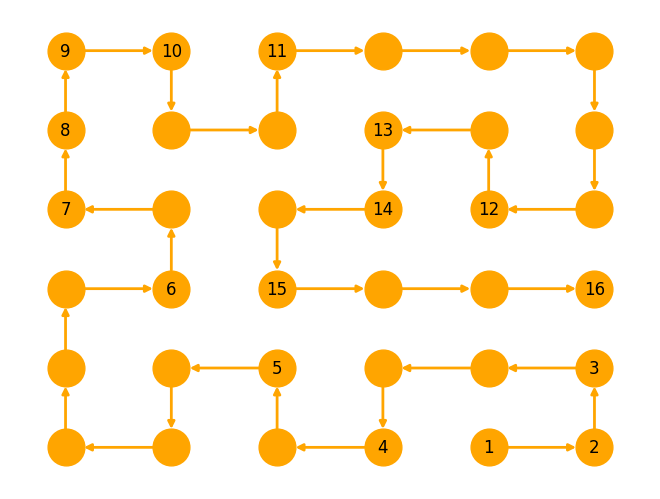

In [4]:
numbered_nodes = {
    (1,1): 9,
    (1,2): 10,
    (1,3): 11,
    (2,1): 8,
    (2,4): 13,
    (3,1): 7,
    (3,4): 14,
    (3,5): 12,
    (4,2): 6,
    (4,3): 15,
    (4,6): 16,
    (5,3): 5,
    (5,6): 3,
    (6,4): 4,
    (6,5): 1,
    (6,6): 2
}
solve_zip(6,6,numbered_nodes)

As expected, the displayed path satisfies all the rules of Zip No. 166.

<figure style="text-align:center;">
    <figcaption>Zip game solution</figcaption>
    <img src="https://cdn.jsdelivr.net/gh/rodrigo-cl-porto/Solving-LinkedIn-Minigames-with-Linear-Optimization/assets/zip_solution.png" style="width:30%;">
    <figcaption>Source: LinkedIn</figcaption>
</figure>

# References

- **Zip**. LinkedIn. Available at https://www.linkedin.com/games/zip/. Accessed on August 29th, 2025.
- **Miller-Tucker-Zemlin Formulation**. AIMMS. December 13th, 2024. Available at https://how-to.aimms.com/Articles/332/332-Miller-Tucker-Zemlin-formulation.html. Accessed on September 2nd, 2025.